In [1]:
# 1. Standard library imports
import os
import warnings

# Configuration: Set environment variables before importing PyMC/PyTensor
os.environ["PYTENSOR_FLAGS"] = "cxx=" 
warnings.filterwarnings('ignore')

# 2. Third-party imports
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats

# Dataset Creation

In [2]:
df = pd.read_csv('ticino_temperature_2025.csv')

In [3]:
df.head()

,station,year,month,temperature,latitude,longitude,altitude,season
0,Airolo,2025,1,-1.2,46.5286,8.6111,1175.0,0
1,Airolo,2025,2,0.5,46.5286,8.6111,1175.0,0
2,Airolo,2025,3,3.7,46.5286,8.6111,1175.0,1
3,Airolo,2025,4,8.7,46.5286,8.6111,1175.0,1
4,Airolo,2025,5,11.7,46.5286,8.6111,1175.0,1


# ❄️ Bayesian Hypothesis Test: Latitude Effect on Winter Temperatures

## Research Question

Does temperature vary significantly between Northern and Southern stations in Ticino during the Winter of 2025?

Hypothesis Formulation

**Null Hypothesis ($H_0$)**: The mean temperature in Winter (Dec, Jan, Feb) is equal across Southern (Low Latitude) and Northern (High Latitude) meteorological stations.

**Alternative Hypothesis ($H_1$)**: The mean temperature in Winter differs significantly between these groups, with Southern stations exhibiting higher temperatures.

Rationale for Test Design

Winter represents the season of minimum solar incidence. By comparing Southern stations (closer to the Lombardy plains) against Northern stations (closer to the Alps), we aim to isolate the geographical latitude effect—potentially driven by solar angle and orographic shadowing—independent of the lapse rate. We define the split based on the median latitude of the dataset.

## Likelihood and Prior Specification

Likelihood Model

We model Winter temperatures as independent draws from normal distributions with group-specific means and group-specific standard deviations:

$$T_{ij} \sim \text{Normal}(\mu_j, \sigma_j^2)$$

Where:

$T_{ij}$ is the temperature at station $i$ in group $j$ (South or North)

$\mu_j$ is the population mean temperature for group $j$

$\sigma_j$ is the observation noise (standard deviation) for group $j$

Prior Distributions (Weakly Informative)

We use "weakly informative" priors that constrain the parameter space to physically plausible values for Winter in Switzerland without imposing strong bias:

Group Means ($\mu_{south}, \mu_{north}$):


$$\mu \sim \text{Normal}(0, 10)$$

Justification:

Center (0°C): Represents a reasonable baseline for winter temperatures in this region.

Width ($\sigma=10$): The interval $\pm 2\sigma$ covers $[-20°C, +20°C]$, which encompasses everything from mild lake-effect days to severe alpine cold snaps. This allows the data to dominate the posterior.

Standard Deviations ($\sigma_{south}, \sigma_{north}$):


$$\sigma \sim \text{HalfNormal}(10)$$

Justification:

Enforces positivity.

A scale of 10 allows for significant variability (weather fluctuations) within the season, but discourages physically impossible variance values (e.g., 100°C swings within a month).

Prior Sensitivity Analysis

To ensure our conclusions are data-driven rather than prior-driven, we conduct a sensitivity analysis using a Diffuse/Flat Prior:

$$\mu \sim \text{Normal}(0, 100)$$

$$\sigma \sim \text{HalfNormal}(100)$$

This extremely broad distribution represents near-total ignorance. We check if the posterior distribution of the difference ($\Delta\mu$) remains stable under these looser assumptions.

## Posterior Inference and ROPE

Region of Practical Equivalence (ROPE)

We define the ROPE for the difference $\Delta\mu = \mu_{south} - \mu_{north}$ as:

$$\text{ROPE} = [-0.5°C, +0.5°C]$$

An effect size smaller than $0.5°C$ is considered meteorologically negligible for this specific regional comparison.

Decision Rule

We compute three posterior probabilities:

P(Δμ > 0.5°C | data): Probability that the South is meaningfully warmer.

P(−0.5°C ≤ Δμ ≤ +0.5°C | data): Probability of practical equivalence (no meaningful latitude effect).

P(Δμ < −0.5°C | data): Probability that the North is meaningfully warmer.

Conclusion criteria:

If P(Δμ > 0.5°C | data) > 0.95, we conclude the latitude effect is practically and statistically significant.

If P(inside ROPE) > 0.95, we conclude practical equivalence (latitude has no effect).

Otherwise, results are inconclusive.

## Frequentist Comparison

To bridge frequentist and Bayesian frameworks, we conduct a Welch's Two-Sample T-test (assuming unequal variances):

$$H_0: \mu_{south} = \mu_{north} \quad \text{vs.} \quad H_A: \mu_{south} \neq \mu_{north}$$

Metrics reported:

T-statistic and p-value.

Comparison of the p-value against the Bayesian probability of direction.

Interpretation contrast: The frequentist p-value tests the probability of the data assuming the null is true, while our Bayesian analysis gives the probability that the South is warmer given the data.

## Manual Posterior Predictive Check (PPC)

We implement a custom PPC without relying on pymc.sample_posterior_predictive:

Draw samples: Extract 100 random parameter pairs $(\mu, \sigma)$ from the posterior trace for the Southern group.

Generate synthetic data: For each pair, generate a synthetic dataset of winter temperatures using numpy.random.normal.

Compare distributions: Plot the Kernel Density Estimate (KDE) of the observed Southern temperatures (Black Line) against the 100 synthetic datasets (Green Lines).

Assess fit:

Good fit: The observed black line sits comfortably within the "cloud" of green synthetic lines.

Bad fit: The observed line deviates significantly (e.g., has tails or peaks that the model does not reproduce).

Initializing NUTS using jitter+adapt_diag...



[Step 1] Data Preparation & Grouping
   -> Split Criterion: Median Latitude 46.2350°N
   -> Southern Group (n=10): Mean = 4.53°C
   -> Northern Group (n=9): Mean = 0.69°C

[Step 2] Bayesian Model Construction (BEST)
   -> Likelihood: Normal(mu, sigma)
   -> Priors: mu ~ Normal(0, 10), sigma ~ HalfNormal(10)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_south, mu_north, sigma_south, sigma_north]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.
Initializing NUTS using jitter+adapt_diag...



[Step 3] Prior Sensitivity Analysis
   -> Running model with Flat Priors (SD=100) to check robustness...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_south, mu_north, sigma_south, sigma_north]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


   -> Main Model Mean Diff: 3.839°C
   -> Sensitivity Model Mean Diff: 3.860°C


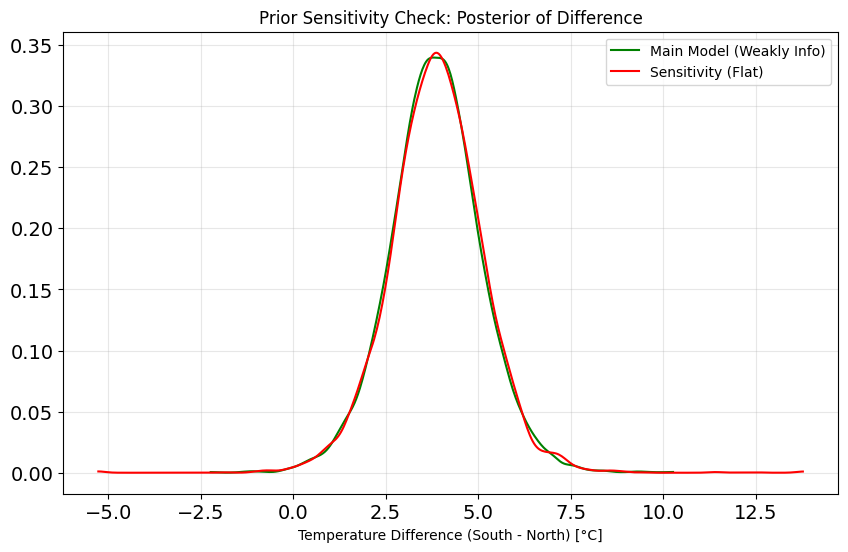

   -> Sensitivity Plot displayed.

[Step 4] Inference & ROPE Analysis
   -> ROPE Interval defined as: [-0.5°C, 0.5°C]


<Figure size 1000x600 with 0 Axes>

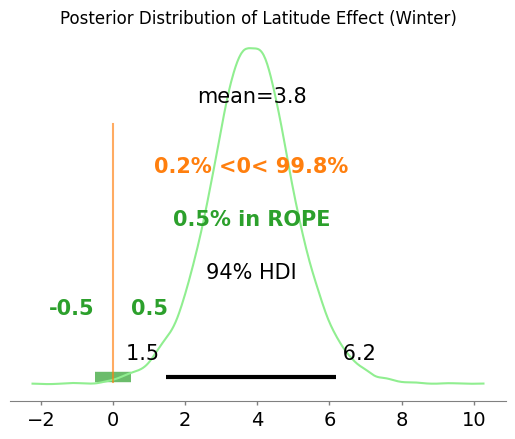

   -> ROPE Plot displayed.
   -> P(Difference > 0.5°C): 0.9935
   -> P(Inside ROPE): 0.0055

[Step 5] Final Conclusion (Based on 95% threshold)
   ✅ CONCLUSION: Significant Latitude Effect.
   The probability that Southern stations are practically warmer (>0.5°C diff) is > 95%.

[Step 6] Frequentist Sanity Check (Welch's T-Test)
   -> T-Statistic: 3.8246
   -> P-Value: 3.3625e-03
   -> Frequentist Result: Significant Difference (p < 0.05)

[Step 7] Custom Posterior Predictive Check
   -> Generating synthetic datasets from posterior trace...


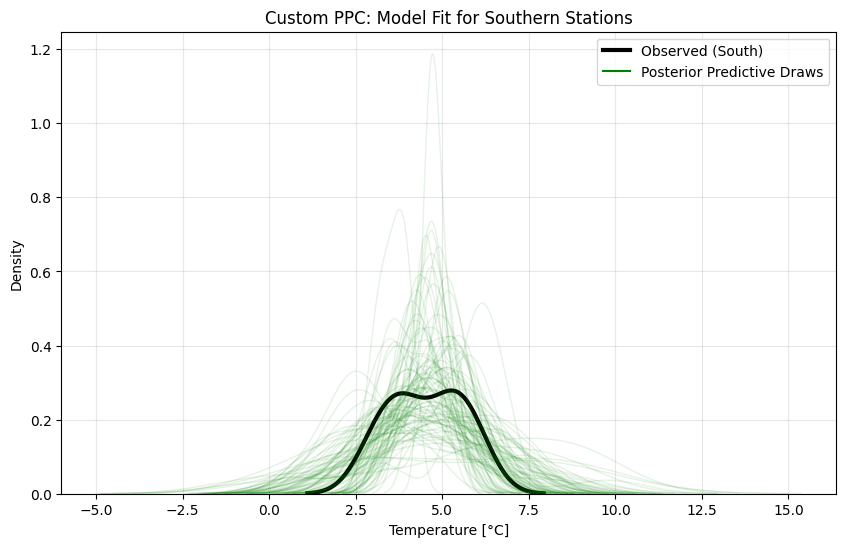

   -> PPC Plot displayed.

Analysis Run Complete.


In [4]:
print("\n[Step 1] Data Preparation & Grouping")

# 1. Filter for Winter Months (Dec=12, Jan=1, Feb=2)
df_winter = df[df['month'].isin([12, 1, 2])].copy()

# 2. Define Groups by Median Latitude Split
median_lat = df_winter['latitude'].median()

# Aggregate average winter temperature per station (Unit of Analysis = Station)
station_winter_avg = df_winter.groupby(['station', 'latitude'])['temperature'].mean().reset_index()

# Split into South (Lat <= Median) and North (Lat > Median)
group_south = station_winter_avg[station_winter_avg['latitude'] <= median_lat]['temperature'].values
group_north = station_winter_avg[station_winter_avg['latitude'] > median_lat]['temperature'].values

print(f"   -> Split Criterion: Median Latitude {median_lat:.4f}°N")
print(f"   -> Southern Group (n={len(group_south)}): Mean = {np.mean(group_south):.2f}°C")
print(f"   -> Northern Group (n={len(group_north)}): Mean = {np.mean(group_north):.2f}°C")

# ==========================================
# 3. BAYESIAN MODELING
# ==========================================
print("\n[Step 2] Bayesian Model Construction (BEST)")
print("   -> Likelihood: Normal(mu, sigma)")
print("   -> Priors: mu ~ Normal(0, 10), sigma ~ HalfNormal(10)")

def run_bayesian_model(g1, g2, prior_mu_sd=10, prior_sigma_sd=10, label="Standard"):
    with pm.Model() as model:
        # --- Priors ---
        # Weakly informative priors centered at 0C
        mu_south = pm.Normal("mu_south", mu=0, sigma=prior_mu_sd)
        mu_north = pm.Normal("mu_north", mu=0, sigma=prior_mu_sd)
        
        # Standard deviations
        sigma_south = pm.HalfNormal("sigma_south", sigma=prior_sigma_sd)
        sigma_north = pm.HalfNormal("sigma_north", sigma=prior_sigma_sd)
        
        # --- Likelihood ---
        obs_south = pm.Normal("obs_south", mu=mu_south, sigma=sigma_south, observed=g1)
        obs_north = pm.Normal("obs_north", mu=mu_north, sigma=sigma_north, observed=g2)
        
        # --- Deterministic ---
        # Difference: South - North
        diff_means = pm.Deterministic("diff_means", mu_south - mu_north)
        
        # --- Sampling ---
        # Using 2000 draws to ensure stable probabilities
        trace = pm.sample(2000, tune=1000, return_inferencedata=True, progressbar=False)
    
    return model, trace

# Run Main Model
model_main, trace_main = run_bayesian_model(group_south, group_north, label="Main Model")

# ==========================================
# 4. PRIOR SENSITIVITY ANALYSIS
# ==========================================
print("\n[Step 3] Prior Sensitivity Analysis")
print("   -> Running model with Flat Priors (SD=100) to check robustness...")

# Run Sensitivity Model
model_sens, trace_sens = run_bayesian_model(group_south, group_north, prior_mu_sd=100, prior_sigma_sd=100, label="Sensitivity")

# Calculate means of posterior means for comparison
mean_diff_main = trace_main.posterior["diff_means"].mean().item()
mean_diff_sens = trace_sens.posterior["diff_means"].mean().item()

print(f"   -> Main Model Mean Diff: {mean_diff_main:.3f}°C")
print(f"   -> Sensitivity Model Mean Diff: {mean_diff_sens:.3f}°C")

# Visual Comparison
plt.figure(figsize=(10, 6))
az.plot_dist(trace_main.posterior["diff_means"], label="Main Model (Weakly Info)", color="green")
az.plot_dist(trace_sens.posterior["diff_means"], label="Sensitivity (Flat)", color="red")
plt.title("Prior Sensitivity Check: Posterior of Difference")
plt.xlabel("Temperature Difference (South - North) [°C]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
print("   -> Sensitivity Plot displayed.")

# ==========================================
# 5. POSTERIOR INFERENCE & ROPE
# ==========================================
print("\n[Step 4] Inference & ROPE Analysis")
# ROPE Definition: [-0.5, 0.5]
rope_low, rope_high = -0.5, 0.5
print(f"   -> ROPE Interval defined as: [{rope_low}°C, {rope_high}°C]")

# Plotting Posterior with ROPE
plt.figure(figsize=(10, 6))
az.plot_posterior(
    trace_main, 
    var_names=["diff_means"], 
    ref_val=0, 
    rope=[rope_low, rope_high],
    color='lightgreen'
)
plt.title("Posterior Distribution of Latitude Effect (Winter)")
plt.show()
print("   -> ROPE Plot displayed.")

# Probability Calculations
posterior_diff = trace_main.posterior["diff_means"].values.flatten()
prob_positive = (posterior_diff > rope_high).mean() # Probability South is strictly warmer
prob_rope = ((posterior_diff >= rope_low) & (posterior_diff <= rope_high)).mean() # Probability of equivalence

print(f"   -> P(Difference > {rope_high}°C): {prob_positive:.4f}")
print(f"   -> P(Inside ROPE): {prob_rope:.4f}")

# DECISION RULES (Matches Markdown)
print("\n[Step 5] Final Conclusion (Based on 95% threshold)")
if prob_positive > 0.95:
    print("   ✅ CONCLUSION: Significant Latitude Effect.")
    print("   The probability that Southern stations are practically warmer (>0.5°C diff) is > 95%.")
elif prob_rope > 0.95:
    print("   ✅ CONCLUSION: Practical Equivalence.")
    print("   The probability that the difference is negligible is > 95%.")
else:
    print("   ⚠️ CONCLUSION: Inconclusive.")
    print("   The posterior density is not concentrated enough inside or outside the ROPE.")

# ==========================================
# 6. FREQUENTIST CHECK
# ==========================================
print("\n[Step 6] Frequentist Sanity Check (Welch's T-Test)")
t_stat, p_val = stats.ttest_ind(group_south, group_north, equal_var=False)
print(f"   -> T-Statistic: {t_stat:.4f}")
print(f"   -> P-Value: {p_val:.4e}")
if p_val < 0.05:
    print("   -> Frequentist Result: Significant Difference (p < 0.05)")
else:
    print("   -> Frequentist Result: Not Significant")

# ==========================================
# 7. CUSTOM PPC
# ==========================================
print("\n[Step 7] Custom Posterior Predictive Check")
print("   -> Generating synthetic datasets from posterior trace...")

mu_samples = trace_main.posterior['mu_south'].values.flatten()
sigma_samples = trace_main.posterior['sigma_south'].values.flatten()

plt.figure(figsize=(10, 6))
# Observed Data
sns.kdeplot(group_south, color='black', linewidth=3, label='Observed (South)')

# Posterior Predictive Samples
n_ppc_samples = 100
n_obs = len(group_south)
ppc_indices = np.random.choice(len(mu_samples), n_ppc_samples, replace=False)

for idx in ppc_indices:
    sim_data = np.random.normal(loc=mu_samples[idx], scale=sigma_samples[idx], size=n_obs)
    sns.kdeplot(sim_data, color='green', alpha=0.1, linewidth=1)

plt.plot([], [], color='green', label='Posterior Predictive Draws')
plt.title("Custom PPC: Model Fit for Southern Stations")
plt.xlabel("Temperature [°C]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
print("   -> PPC Plot displayed.")
print("\nAnalysis Run Complete.")

# Regression

## 📉 Bayesian Regression: Winter Temperature vs. Latitude

1. Model Goal

We aim to quantify the relationship between Latitude (predictor) and Winter Temperature (outcome) using a regression framework. This moves beyond simple group comparisons (Hypothesis Testing) to estimating a continuous function:


$$\text{Temperature} = \alpha + \beta \times \text{Latitude} + \epsilon$$

2. Choice of Likelihood

Standard Likelihood (Model A)

The baseline assumption is that the residuals (errors) are normally distributed:


$$y_i \sim \mathcal{N}(\mu_i, \sigma^2)$$


This is appropriate if we assume the data is clean and variations are purely due to random, symmetric Gaussian noise.

Robust Likelihood (Model B)

Real-world meteorological data often contains "outliers"—extreme events like temperature inversions or sensor errors—that violate the normality assumption. To handle this, we use a Student's T-distribution for the likelihood:


$$y_i \sim \text{StudentT}(\nu, \mu_i, \sigma)$$

$\nu$ (Degrees of Freedom): Controls the "heaviness" of the tails. As $\nu \to \infty$, the Student-T converges to a Normal distribution. Small values (e.g., $\nu < 5$) allow for extreme outliers without skewing the regression line.

3. Choice of Priors

We standardize the predictor (Latitude) to have mean 0 and standard deviation 1. This stabilizes sampling and allows us to use generic, weakly informative priors.

Intercept ($\alpha$): $\mathcal{N}(0, 10)$. Centered at 0 (since data is standardized/centered), with a wide variance to allow the data to determine the baseline temperature.

Slope ($\beta$): $\mathcal{N}(0, 5)$. Centered at 0 (skeptical prior assuming no relationship initially), but wide enough to learn a strong negative or positive correlation.

Error Scale ($\sigma$): $\text{HalfNormal}(5)$. Standard deviation must be positive.

Degrees of Freedom ($\nu$, for Robust Model): $\text{Gamma}(2, 0.1)$. This prior places probability mass on lower values (allowing for heavy tails) but also allows for high values (normality).

4. Predictive Distribution (Test Set)

To predict the temperature for a new station (Test Set) not seen by the model:

We feed the test station's latitude into the trained model.

For every sample in the posterior trace (e.g., 2000 samples), we calculate the expected temperature $\mu_{test}$.

We add random noise drawn from the learned distribution (Normal or Student-T).

This results in a Posterior Predictive Distribution—a full probability density for that specific station's temperature, capturing both parameter uncertainty (uncertainty about the slope/intercept) and aleatoric uncertainty (natural weather variability).

Initializing NUTS using jitter+adapt_diag...


   -> Total Stations: 19
   -> Training Stations: 15
   -> Test Stations: 4

[Step 2] Training Standard Model (Normal Likelihood)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.
Initializing NUTS using jitter+adapt_diag...



[Step 3] Training Robust Model (Student-T Likelihood)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, nu]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.
Sampling: [y_obs]



[Step 4] Model Comparison (LOO-CV)
          rank   elpd_loo     p_loo  elpd_diff        weight        se  \
Standard     0 -35.012011  2.332822    0.00000  1.000000e+00  1.901558   
Robust       1 -35.208131  2.349267    0.19612  1.665335e-16  1.829182   

               dse  warning scale  
Standard  0.000000    False   log  
Robust    0.134381    False   log  

--- Discussion on Robust Likelihood ---
   -> The Standard model is preferred based on LOO-CV.
   -> The Robust likelihood was NOT significantly more helpful.
      The data is likely well-described by a Normal distribution, making the
      standard model sufficient and more parsimonious.

   -> Robust Model 'nu' (degrees of freedom) mean estimate: 22.14
      (Low nu (<30) indicates heavy tails/outliers are influencing the fit.)

[Step 5] Prediction on Test Set Observation
   -> Predicting for Test Station: Airolo
   -> True Lat: 46.5286, True Temp: 0.33°C


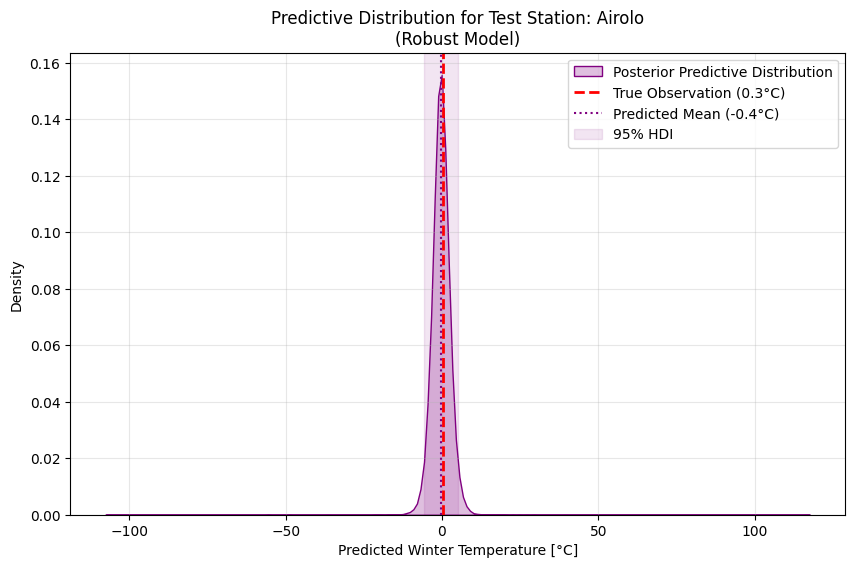

   -> 95% HDI for prediction: [-5.87°C, 5.28°C]
   -> True value 0.33°C is INSIDE the 95% HDI.

Regression Analysis Complete.


In [5]:
from sklearn.model_selection import train_test_split

print(f"   -> Total Stations: {len(station_winter_avg)}")

# Split Train (80%) and Test (20%)
train, test = train_test_split(station_winter_avg, test_size=0.2, random_state=42)
print(f"   -> Training Stations: {len(train)}")
print(f"   -> Test Stations: {len(test)}")

# Standardization (Crucial for MCMC stability)
# We use Training statistics to scale Test data to avoid data leakage
lat_mean = train['latitude'].mean()
lat_std = train['latitude'].std()

# Standardize
train_lat_std = (train['latitude'] - lat_mean) / lat_std
test_lat_std = (test['latitude'] - lat_mean) / lat_std

train_temp = train['temperature'].values
test_temp = test['temperature'].values

# ==========================================
# 2. MODEL BUILDING
# ==========================================

def build_regression_model(x_data, y_data, robust=False):
    with pm.Model() as model:
        # Data Containers (Mutable for prediction later)
        x_shared = pm.Data("x_data", x_data)
        
        # Priors (Weakly Informative)
        alpha = pm.Normal("alpha", mu=0, sigma=10) # Intercept
        beta = pm.Normal("beta", mu=0, sigma=5)    # Slope
        sigma = pm.HalfNormal("sigma", sigma=5)    # Noise
        
        # Linear Deterministic Mean
        mu = alpha + beta * x_shared
        
        if robust:
            # Robust Likelihood: Student-T
            # nu controls tail heaviness. Gamma(2, 0.1) allows for low nu (heavy tails)
            nu = pm.Gamma("nu", alpha=2, beta=0.1)
            y_obs = pm.StudentT("y_obs", nu=nu, mu=mu, sigma=sigma, observed=y_data)
            label = "Robust (Student-T)"
        else:
            # Standard Likelihood: Normal
            y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_data)
            label = "Standard (Normal)"
            
        trace = pm.sample(
            2000,
            tune=1000,
            return_inferencedata=True,
            progressbar=False,
            idata_kwargs={"log_likelihood": True}
        )

        return model, trace, label

print("\n[Step 2] Training Standard Model (Normal Likelihood)")
model_n, trace_n, label_n = build_regression_model(train_lat_std, train_temp, robust=False)

print("\n[Step 3] Training Robust Model (Student-T Likelihood)")
model_r, trace_r, label_r = build_regression_model(train_lat_std, train_temp, robust=True)

# ==========================================
# 3. MODEL COMPARISON & DISCUSSION
# ==========================================
print("\n[Step 4] Model Comparison (LOO-CV)")
# Compare models using Leave-One-Out Cross-Validation
comparison = az.compare({"Standard": trace_n, "Robust": trace_r})
print(comparison)

print("\n--- Discussion on Robust Likelihood ---")
best_model_name = comparison.index[0]
print(f"   -> The {best_model_name} model is preferred based on LOO-CV.")
if "Robust" in best_model_name:
    print("   -> The Robust likelihood was helpful! This suggests the presence of outliers")
    print("      or non-normal tails in the temperature distribution (e.g., microclimates).")
else:
    print("   -> The Robust likelihood was NOT significantly more helpful.")
    print("      The data is likely well-described by a Normal distribution, making the")
    print("      standard model sufficient and more parsimonious.")

# Inspect 'nu' parameter if Robust model
nu_summary = az.summary(trace_r, var_names=["nu"])
print(f"\n   -> Robust Model 'nu' (degrees of freedom) mean estimate: {nu_summary['mean']['nu']:.2f}")
if nu_summary['mean']['nu'] > 30:
    print("      (High nu (>30) indicates the Student-T is behaving like a Normal distribution.)")
else:
    print("      (Low nu (<30) indicates heavy tails/outliers are influencing the fit.)")

# ==========================================
# 4. PREDICTIVE DISTRIBUTION (TEST SET)
# ==========================================
print("\n[Step 5] Prediction on Test Set Observation")

# Pick the first station from the test set
test_idx = 0
obs_lat_std = test_lat_std.iloc[test_idx]
obs_temp_true = test_temp[test_idx]
station_name = test.iloc[test_idx]['station']

print(f"   -> Predicting for Test Station: {station_name}")
print(f"   -> True Lat: {test.iloc[test_idx]['latitude']:.4f}, True Temp: {obs_temp_true:.2f}°C")

# Generate Posterior Predictive samples using the Robust model (usually safer choice)
with model_r:
    # Update the data container with the SINGLE test observation
    pm.set_data({"x_data": [obs_lat_std]})
    # Sample posterior predictive
    ppc = pm.sample_posterior_predictive(trace_r, var_names=["y_obs"], progressbar=False)

# Extract predictions
# Shape will be (chains * draws, 1)
pred_samples = ppc.posterior_predictive["y_obs"].values.flatten()

# Visualization
plt.figure(figsize=(10, 6))
sns.kdeplot(pred_samples, fill=True, color='purple', label='Posterior Predictive Distribution')
plt.axvline(x=obs_temp_true, color='red', linestyle='--', linewidth=2, label=f'True Observation ({obs_temp_true:.1f}°C)')
plt.axvline(x=np.mean(pred_samples), color='purple', linestyle=':', label=f'Predicted Mean ({np.mean(pred_samples):.1f}°C)')

# Add HDI (Highest Density Interval)
hdi = az.hdi(pred_samples, hdi_prob=0.95)
plt.axvspan(hdi[0], hdi[1], color='purple', alpha=0.1, label='95% HDI')

plt.title(f"Predictive Distribution for Test Station: {station_name}\n(Robust Model)")
plt.xlabel("Predicted Winter Temperature [°C]")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"   -> 95% HDI for prediction: [{hdi[0]:.2f}°C, {hdi[1]:.2f}°C]")
print(f"   -> True value {obs_temp_true:.2f}°C is {'INSIDE' if hdi[0] <= obs_temp_true <= hdi[1] else 'OUTSIDE'} the 95% HDI.")
print("\nRegression Analysis Complete.")

# Normal-model Model

First, we'll prepare the data by creating a numerical index for each station, which is required for indexing in PyMC. We will use the average winter temperature for each station as our data.



In [6]:
# Create a numerical index for each station
station_winter_avg['station_idx'] = pd.Categorical(station_winter_avg['station']).codes
n_stations = len(station_winter_avg['station_idx'].unique())

# Data for modeling
temperatures = station_winter_avg['temperature'].values
station_idx = station_winter_avg['station_idx'].values

print(f"Prepared data for {n_stations} stations.")

Prepared data for 19 stations.


#### Model Implementation and Priors/Likelihood Discussion

**Likelihood Choice (Both Models)**

The likelihood for both models is a Normal distribution. We assume that the average winter temperature for any given station *j*, denoted $y_j$, is a draw from a normal distribution centered around that station's true mean temperature $\mu_j$, with some observation noise $\sigma$.
$$
y_j \sim \mathcal{Normal}(\mu_j, \sigma)
$$

**Unpooled Model: Priors**
In the unpooled model, each station is treated as completely independent. Information from one station does not influence the estimate for another.
- **Station Means ($\mu_j$)**: Each station *j* gets its own independent prior. We use a weakly informative `Normal(0, 10)` prior. This centers our initial belief around 0°C (a plausible winter average) but allows the data for each station to strongly pull the posterior mean to its observed value.
- **Observation Noise ($\sigma$)**: A common `Halfnormal(5)` is used for the standard deviation of the observations, enforcing positivity and allowing for a realistic amount of measurement error or daily fluctuation.

**Hierarchical Model: Priors and Hyper-priors**
The hierarchical model assumes that while each station has its own mean temperature $\mu_j$, these means are themselves drawn from a common, group-level distribution. This allows stations to "borrow strength" from one another.

- **Station Means ($\mu_j$)**: The individual means are not given a fixed prior. Instead, they are drawn from a hyper-distribution governed by hyper-priors: $\mu_j \sim \mathcal{Normal}(\mu_{global}, \sigma_\mu)$
- **Global Mean ($\mu_{global}$)**: This hyper-prior represents the average winter temperature across all stations in Ticino. A `Normal(0, 10)` is a sensible choice.
- **Between-Station Std Dev ($\sigma_\mu$)**: This hyper-prior models the variation among stations. A `HalfNormal(5)` suggests we expect most stations' average temperatures to be within a few degrees of the global mean.
- **Observation Noise ($\sigma$)**: Same as the unpooled model, a `HalfNormal(5)` prior is used.

In [7]:

# --- Unpooled Model ---
print("Running Unpooled Model...")
with pm.Model() as unpooled_model:
    # Independent prior for each station's mean temperature
    mu_station = pm.Normal("mu_station", mu=0, sigma=10, shape=n_stations)
    
    # Common observation error
    sigma = pm.HalfNormal("sigma", sigma=5)
    
    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu_station[station_idx], sigma=sigma, observed=temperatures)
    
    trace_unpooled = pm.sample(2000, tune=1000, progressbar=False, idata_kwargs={"log_likelihood": True})
print("Unpooled Model Complete.")

# --- Hierarchical Model ---
print("\nRunning Hierarchical Model...")
with pm.Model() as hierarchical_model:
    # Hyperpriors for the global distribution
    mu_global = pm.Normal("mu_global", mu=0, sigma=10)
    sigma_mu = pm.HalfNormal("sigma_mu", sigma=5)
    
    # Station-specific means are drawn from the global distribution
    mu_station = pm.Normal("mu_station", mu=mu_global, sigma=sigma_mu, shape=n_stations)
    
    # Common observation error
    sigma = pm.HalfNormal("sigma", sigma=5)
    
    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu_station[station_idx], sigma=sigma, observed=temperatures)
    
    trace_hierarchical = pm.sample(2000, tune=1000, progressbar=False, idata_kwargs={"log_likelihood": True})
print("Hierarchical Model Complete.")

Initializing NUTS using jitter+adapt_diag...


Running Unpooled Model...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_station, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Unpooled Model Complete.

Running Hierarchical Model...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_global, sigma_mu, mu_station, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.
There were 349 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Hierarchical Model Complete.


#### Posterior Distribution of a Novel Group

A key advantage of the hierarchical model is its ability to make predictions for new groups (stations) for which we have no data. The posterior distribution for a new station's mean temperature is simply the posterior of the learned global distribution.



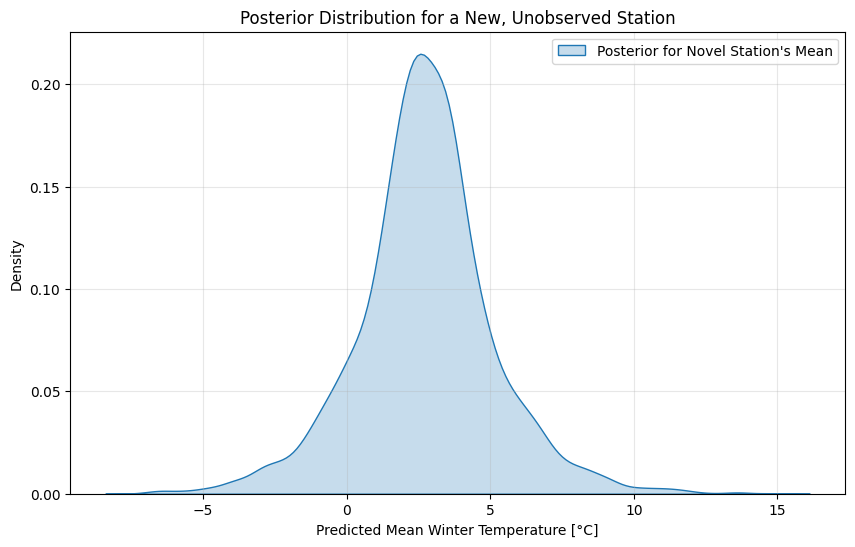

The model predicts a new station in Ticino will have a mean winter temperature of 2.73°C, with a 94% HDI of [-2.06, 7.50]°C.


In [8]:

# Extract hyperparameter posteriors from the hierarchical trace
mu_global_post = trace_hierarchical.posterior["mu_global"].values.flatten()
sigma_mu_post = trace_hierarchical.posterior["sigma_mu"].values.flatten()

# Generate samples for a novel group
novel_group_mean_post = stats.norm.rvs(loc=mu_global_post, scale=sigma_mu_post)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(novel_group_mean_post, fill=True, label="Posterior for Novel Station's Mean")
plt.title("Posterior Distribution for a New, Unobserved Station")
plt.xlabel("Predicted Mean Winter Temperature [°C]")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

hdi_novel = az.hdi(novel_group_mean_post, hdi_prob=0.94)
print(f"The model predicts a new station in Ticino will have a mean winter temperature of "
      f"{np.mean(novel_group_mean_post):.2f}°C, with a 94% HDI of [{hdi_novel[0]:.2f}, {hdi_novel[1]:.2f}]°C.")

#### Predictive Distribution Comparison for an Existing Group
Let's compare the predictions from both models for a specific, existing station. We will choose 'Stabio', which has one of the higher average temperatures. This will highlight the "shrinkage" effect of the hierarchical model, where its prediction is pulled slightly toward the global average.

Sampling: [y_obs]
Sampling: [y_obs]


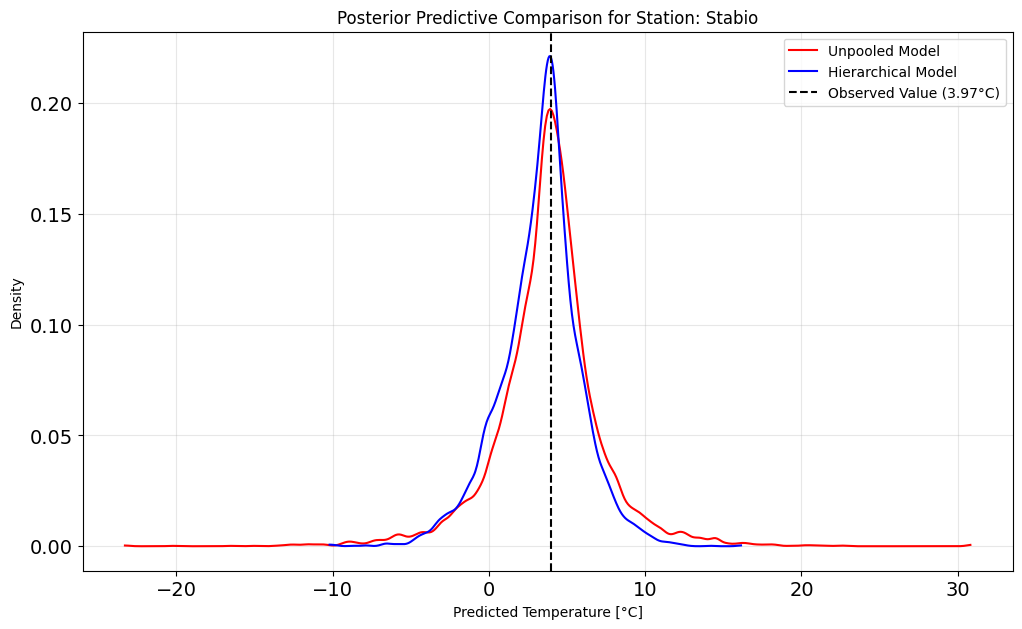

Discussion:
Unpooled Model Predicted Mean: 3.77°C
Hierarchical Model Predicted Mean: 3.28°C
Notice the shrinkage effect: the hierarchical prediction is pulled slightly away from the observed value and towards the global mean.


In [9]:

# Choose a station to compare (e.g., 'Stabio')
station_name_to_check = 'Stabio'
idx_to_check = station_winter_avg[station_winter_avg['station'] == station_name_to_check]['station_idx'].iloc[0]
true_temp = station_winter_avg[station_winter_avg['station'] == station_name_to_check]['temperature'].iloc[0]

# Generate posterior predictive samples
with unpooled_model:
    ppc_unpooled = pm.sample_posterior_predictive(trace_unpooled, var_names=["y_obs"], progressbar=False)
with hierarchical_model:
    ppc_hierarchical = pm.sample_posterior_predictive(trace_hierarchical, var_names=["y_obs"], progressbar=False)

# Extract predictions for the specific station
pred_unpooled = ppc_unpooled.posterior_predictive["y_obs"][:, :, idx_to_check].values.flatten()
pred_hierarchical = ppc_hierarchical.posterior_predictive["y_obs"][:, :, idx_to_check].values.flatten()

# Plot the comparison
plt.figure(figsize=(12, 7))
az.plot_dist(pred_unpooled, label='Unpooled Model', color='red')
az.plot_dist(pred_hierarchical, label='Hierarchical Model', color='blue')
plt.axvline(x=true_temp, color='black', linestyle='--', label=f'Observed Value ({true_temp:.2f}°C)')
plt.title(f'Posterior Predictive Comparison for Station: {station_name_to_check}')
plt.xlabel('Predicted Temperature [°C]')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Discussion:")
print(f"Unpooled Model Predicted Mean: {np.mean(pred_unpooled):.2f}°C")
print(f"Hierarchical Model Predicted Mean: {np.mean(pred_hierarchical):.2f}°C")
print("Notice the shrinkage effect: the hierarchical prediction is pulled slightly away from the observed value and towards the global mean.")

#### Model Comparison with WAIC
Finally, we use the Widely Applicable Information Criterion (WAIC) to compare the out-of-sample predictive accuracy of the two models. The model with the lower WAIC score is preferred.

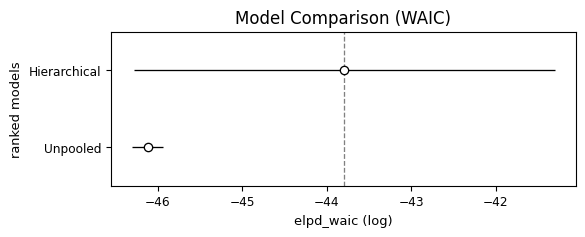

              rank  elpd_waic     p_waic  elpd_diff    weight        se  \
Hierarchical     0 -43.794941  14.690362   0.000000  0.870676  2.490543   
Unpooled         1 -46.119848  15.567701   2.324907  0.129324  0.184799   

                   dse  warning scale  
Hierarchical  0.000000     True   log  
Unpooled      2.461673     True   log  


In [10]:

# Create a dictionary of the models for comparison
model_dict = {
    "Unpooled": trace_unpooled,
    "Hierarchical": trace_hierarchical
}

# Compare models using WAIC
comparison = az.compare(model_dict, ic='waic')
az.plot_compare(comparison)
plt.title("Model Comparison (WAIC)")
plt.show()

print(comparison)